<h1>IAU projekt 1. fáza</h1>
<h3>Autori: Jakub Grúber(50%), Maria Fedosenya(50%)</h3>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
from sklearn import preprocessing
from datetime import datetime, date
import numpy as np

from geopy.geocoders import Nominatim 
from decimal import Decimal 
from unidecode import unidecode

pd.set_option('display.max_columns', 25) #nastavené kvôli sessions.csv, ktoré má 25 stĺpcov, aby sa dali všetky prezrieť

<h1>Načítanie dát zo súborov</h1>

In [4]:
prod_filepath = "data/product.csv"
products = pd.read_csv(prod_filepath, sep='\t')
products.head()

,code,location,store_name,product_ean
0,RU,Europe/Moscow,Kashira,8840337777778
1,SK,Europe/Bratislava,Skalica,9613080891331
2,PH,Asia/Manila,Antipolo,8545276183603
3,PK,Asia/Karachi,Larkana,9999281937499
4,CN,Asia/Shanghai,Hushitai,1423598805373


In [5]:
sess_filepath = "data/session.csv"
sessions = pd.read_csv(sess_filepath, sep='\t')
sessions.head()

,pct_scroll_move,screen_width,ack,pct_mouse_move,scroll_move_total_rel_distance,page_activity_duration,pct_doubleclick,pct_click,total_load_time,mouse_move_total_rel_distance,product_ean,pct_click_product_info,browser_name,screen_height,pct_wild_mouse,pct_mouse_click,pct_input,session_duration,wild_mouse_duration,session_start,pct_scroll_move_duration,pct_scrandom,pct_rage_click,session_id,user_id
0,44.92257,1366,1.0,8.79303,11.16238,5.45167,9.31170,10.35168,2.81337,7.79215,4142933212429,41.07557,chrome,1080,53.33923,10.65208,0.00646,116.78143,5.44105,2021-05-11 10:16:37,11.39851,60.96280,42.77314,1126926,2369
1,53.93169,1280,0.0,10.69797,13.20789,8.03161,11.33962,7.58887,0.11913,13.78957,6554259262213,52.52006,chrome,1080,69.70571,8.32826,0.07267,134.68835,9.51278,2023-07-07 17:38:03,9.48454,56.71155,30.83474,103955,1186
2,41.66225,lower,1.0,11.45911,9.16087,7.73080,9.19028,8.11378,2.60292,5.95620,3525947927861,38.74596,edge,768,72.87642,10.18567,0.02227,126.47138,8.10733,2019-07-24 12:15:27,9.51528,58.17433,39.30398,731099,1265
3,37.59937,lower,1.0,9.78386,6.38416,9.70961,7.42759,6.54811,6.55699,6.36864,9631384503705,62.74747,safari,600,54.03365,7.75790,0.05988,263.06076,9.31265,2022-06-10 17:52:37,4.91020,68.47422,46.14026,1379903,467
4,62.70254,higher,0.0,7.39008,6.09215,11.10614,10.94899,8.45322,0.85335,7.94163,2238487280389,41.10241,edge,600,60.07533,7.59956,1.45341,146.88323,12.60862,2020-09-07 15:03:13,10.63283,28.45915,42.41093,691237,594


In [6]:
user_filepath = "data/user.csv"
users = pd.read_csv(user_filepath, sep='\t')
users.head()

,sex,user_id,current_location,address,job,name,race,mail,username,registration,birthdate
0,M,1270,"(Decimal('43.6199585'), Decimal('-39.027502'))",Sámova 235\n750 67 Police nad Metují,Lawyer,MUDr. Přemysl Říha,NaN,stastnyrostislav@seznam.cz,ales00,"08/23/2023, 00:00:00",1981-08-08
1,F,146,"(Decimal('67.5016935'), Decimal('169.135745'))",Döringstr. 1/8\n09217 Staßfurt,Augenoptiker,Verena Zirme,NaN,marinaschueler@aol.de,schweitzertoni,2022-07-02,2010-09-15
2,NaN,2178,"(Decimal('-83.0843785'), Decimal('35.417096'))","Stretto Surian, 1 Appartamento 5\n09071, Abbas...",NaN,Sabatino Salvemini,NaN,alberto76@virgilio.it,rviviani,26 Oct 2017,1957-07-10
3,NaN,1211,"(Decimal('85.896300'), Decimal('-141.411207'))",岡山県我孫子市上広谷4丁目16番1号 上野桜木パーク629,NaN,青木 稔,NaN,nishimuraasuka@yahoo.com,fmatsumoto,22 Feb 2020,1961-03-02
4,F,1678,"(Decimal('71.468916'), Decimal('-69.232181'))",USS Nelson\nFPO AE 34617,NaN,Vicki Lopez,NaN,ghowell@yahoo.com,nreed,2022/02/14,NaN


<h1>Analýza štruktúry dát</h1>

Na zistenie zakladných informácii o tabuľkách sme použili metódu `info()`, a keďže funkcia `describe()` počíta hodnoty na základe číselných údajov, využijeme ju len vtedy, ak to bude mať zmysel. <br>

Tabuľka **users** má 2588 záznamov, 11 stĺpcov s nasledujúcimi charakteristikami:
<ul>
<li>sex - pohlavie, F/M alebo NaN</li>
<li>user_id - identifikačné číslo používateľa, typu integer</li>
<li>current_location - je miesto, kde sa používateľ nachádza</li>
<li>address - adresa používateľa</li>
<li>job - zamestnanie používateľa<</li>
<li>name - meno používateľa</li>
<li>race - rasa používateľa</li>
<li>mail - email, ktorý  užívateľ používa</li>
<li>username - používateľské meno</li>
<li>registration - dátum registrície</li>
<li>birthdate - dátum narodenia</li>
</ul>

In [7]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2588 entries, 0 to 2587
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   sex               1294 non-null   object
 1   user_id           2588 non-null   int64 
 2   current_location  2459 non-null   object
 3   address           2200 non-null   object
 4   job               1035 non-null   object
 5   name              2588 non-null   object
 6   race              776 non-null    object
 7   mail              2588 non-null   object
 8   username          2588 non-null   object
 9   registration      2588 non-null   object
 10  birthdate         1423 non-null   object
dtypes: int64(1), object(10)
memory usage: 222.5+ KB


Tabuľka **products** má 14912 záznamov a 4 atribúty:
<ul>
<li>code - kód štátu</li>
<li>location - miesto</li>
<li>store_name - názov obchodu</li>
<li>product_ean - EAN kód produktu, typ integer</li>
</ul>

In [8]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14912 entries, 0 to 14911
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   code         14900 non-null  object
 1   location     14912 non-null  object
 2   store_name   14912 non-null  object
 3   product_ean  14912 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 466.1+ KB


Tabuľka **sessions** má 11043 záznamov, 25 stĺpcov. Pri tejto tabuľke uvádzame aj `describe()` pretože má veľa číselných údajov, ktorým má zmysel uvádzať štatistické údaje.

In [9]:
sessions.info()
sessions.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11043 entries, 0 to 11042
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   pct_scroll_move                 11032 non-null  float64
 1   screen_width                    11043 non-null  object 
 2   ack                             11043 non-null  float64
 3   pct_mouse_move                  11032 non-null  float64
 4   scroll_move_total_rel_distance  11032 non-null  float64
 5   page_activity_duration          11032 non-null  float64
 6   pct_doubleclick                 11032 non-null  float64
 7   pct_click                       11032 non-null  float64
 8   total_load_time                 11043 non-null  float64
 9   mouse_move_total_rel_distance   11031 non-null  float64
 10  product_ean                     11043 non-null  int64  
 11  pct_click_product_info          11032 non-null  float64
 12  browser_name                    

,pct_scroll_move,ack,pct_mouse_move,scroll_move_total_rel_distance,page_activity_duration,pct_doubleclick,pct_click,total_load_time,mouse_move_total_rel_distance,product_ean,pct_click_product_info,pct_wild_mouse,pct_mouse_click,pct_input,session_duration,wild_mouse_duration,pct_scroll_move_duration,pct_scrandom,pct_rage_click,session_id,user_id
count,11032.000000,11043.000000,11032.000000,11032.000000,11032.000000,11032.000000,11032.000000,11043.000000,11031.000000,1.104300e+04,11032.000000,11032.000000,11032.000000,11032.000000,11043.000000,11032.000000,11032.000000,11032.000000,11032.000000,1.104300e+04,11043.000000
mean,51.598736,0.549217,9.956045,9.433332,9.048019,9.791655,9.009297,3.983034,8.116635,4.976341e+12,51.367468,50.746666,9.037040,0.387147,150.120858,9.027668,9.801604,48.827050,51.134057,7.476908e+05,1253.587612
std,12.603880,0.497594,1.996056,3.370660,2.200975,2.080895,1.001416,2.820560,2.147599,2.898641e+12,12.732629,12.964515,1.001694,1.987929,60.395237,2.341253,1.961457,13.833425,13.030987,4.321667e+05,722.973175
min,0.000000,0.000000,2.165200,0.000000,2.812950,2.268070,5.214400,0.003570,1.228680,1.234528e+09,0.000000,0.000000,5.272990,0.000000,-47.247120,0.648860,2.587140,0.000000,0.000000,1.249000e+03,0.000000
25%,43.227652,0.000000,8.746925,6.725008,7.308185,8.397730,8.342118,1.908750,6.593985,2.482877e+12,42.752547,42.035492,8.358828,0.014138,108.955965,7.257557,8.613705,39.479665,42.549657,3.694335e+05,630.000000
50%,51.492390,1.000000,10.229970,9.014625,9.046810,10.061465,9.013655,3.334810,7.980590,4.969185e+12,51.327285,50.541550,9.042620,0.051710,150.993030,9.134175,10.177305,48.826865,51.024950,7.517470e+05,1255.000000
75%,60.105700,1.000000,11.381840,12.184798,10.750452,11.278697,9.679718,5.354640,9.649370,7.486987e+12,59.910635,59.323082,9.707045,0.249630,190.924920,10.824945,11.195578,57.866447,59.887293,1.121034e+06,1879.000000
max,100.000000,1.000000,15.912470,20.349730,16.572150,16.180380,12.943650,23.487790,15.791510,9.997623e+12,100.000000,100.000000,12.965960,100.000000,366.445590,16.845850,15.529330,100.000000,100.000000,1.499931e+06,2499.000000


<h1>Identifikácia problémov v dátach s prvotným riešením </h1>
Pred ďalšou prácou s dátami, je vhodné si ich upraviť do vhodného formátu a zbaviť sa redundantných a duplicitných informácii. <br>

Najprv skontrolujeme, či máme nadbytočné záznamy, ktorých sa vieme zbaviť. Zistíme, či sú niektoré riadky duplicitné. 

In [10]:
users_duplicates = users[users.duplicated()]
len(users_duplicates)

0

In [11]:
products_duplicates = products[products.duplicated()]
len(products_duplicates)

0

In [12]:
sessions_duplicates = sessions[sessions.duplicated()]
len(sessions_duplicates)

131

Z výsledku vidíme, že datasety **users** a **products** nemajú duplicitné záznamy. V datasete **sessions** sa však nachádza 131 duplikátov, ktoré cheme odstrániť

In [13]:
sessions = sessions.drop_duplicates()
sessions_duplicates = sessions[sessions.duplicated()]
len(sessions_duplicates)

0

<h4>Úprava datasetu users</h4>
Dátumy v rámci atribútu registration nemajú jednotnú formu, preto si ich upravíme do jedného formátu. 

In [14]:
users["registration"] = pd.to_datetime(users.registration, format="mixed")
users["registration"].head(3)

0   2023-08-23
1   2022-07-02
2   2017-10-26
Name: registration, dtype: datetime64[ns]

Dátumy narodenia majú jednotný format, avšak užitočnejšou informáciou by bol vek používateľov, preto si vytvoríme nový stĺpec **age**.

In [15]:
def get_age(dob):
    try:
        dob = datetime.strptime(dob, "%Y-%m-%d").date() 
        today = date.today() 

        return today.year - dob.year - ((today.month,  today.day) < (dob.month, dob.day))
    except:
        return np.nan

users['age'] = users['birthdate'].apply(get_age)
users['age'].head(5)

0    42.0
1    13.0
2    66.0
3    62.0
4     NaN
Name: age, dtype: float64

In [16]:
users.age.unique()

array([ 42.,  13.,  66.,  62.,  nan,  68.,  11.,  49.,  18.,  73.,  28.,
         7., 101., 107., 100.,  95.,  39.,  59.,  31.,  71.,  98.,   9.,
         4., 109.,  84.,  86.,  46.,  47.,  56.,  33.,  64., 110.,  24.,
        19.,  40.,  58.,  78.,  87., 115.,  99.,  83.,   1.,  15.,  55.,
       106.,  14.,  45.,  12.,  97.,  17.,   6., 113.,  29.,  85.,  90.,
        65.,  32.,  96.,  20.,  60.,  70.,  61.,  79.,  53.,  93.,  34.,
       105.,  51.,  38.,  81.,  75.,  74., 114.,  26., 111.,  89.,  72.,
        22.,  16.,  67.,  10.,  69.,  43.,  76.,  35., 112.,   5.,  91.,
        92.,  37.,  27.,  57.,  44., 108.,  54.,  52.,  80., 102.,  48.,
        41.,   8.,   0.,  21., 104.,  88.,  77.,  30.,  25.,  82.,  23.,
       103.,  36.,  94., 116.,   3.,   2.,  50.,  63.])

Vo veku používateľov máme aj zvláštne hodnoty ako napríklad 1 rok, 2 roky atď. Tieto hodnoty (menšie ako 6 rokov) zmeníme na NaN, nakoľko podľa nás vznikli, lebo užívatelia klamali pri registrácií

In [17]:
users[users.age < 6] = np.nan

In [18]:
users.age.min()

6.0

In [19]:
users['race'].unique()

array([nan, 'unspecified', 'white', 'indian', 'black', 'asian'],
      dtype=object)

Upravíme unspecified a nan na NaN.

In [20]:
users['race'] = users['race'].astype(str).replace("unspecified", np.nan)
users['race'] = users['race'].astype(str).replace("nan", np.nan)

Prepísanie stringov z users do znakov anglickej abecedy

In [21]:
#uprava adresy, prace a mena na anglicku abecedu
columns_to_translate = ["address", "job", "name"]

for column in columns_to_translate:
    for index, value in users.loc[:, column].items():
        if isinstance(value, str):
            updated_value = unidecode(value.replace("\n", " "))
            users.at[index, column] = updated_value

users.head()

,sex,user_id,current_location,address,job,name,race,mail,username,registration,birthdate,age
0,M,1270.0,"(Decimal('43.6199585'), Decimal('-39.027502'))",Samova 235 750 67 Police nad Metuji,Lawyer,MUDr. Premysl Riha,NaN,stastnyrostislav@seznam.cz,ales00,2023-08-23,1981-08-08,42.0
1,F,146.0,"(Decimal('67.5016935'), Decimal('169.135745'))",Doringstr. 1/8 09217 Stassfurt,Augenoptiker,Verena Zirme,NaN,marinaschueler@aol.de,schweitzertoni,2022-07-02,2010-09-15,13.0
2,NaN,2178.0,"(Decimal('-83.0843785'), Decimal('35.417096'))","Stretto Surian, 1 Appartamento 5 09071, Abbasa...",NaN,Sabatino Salvemini,NaN,alberto76@virgilio.it,rviviani,2017-10-26,1957-07-10,66.0
3,NaN,1211.0,"(Decimal('85.896300'), Decimal('-141.411207'))",Gang Shan Xian Wo Sun Zi Shi Shang Guang Gu 4D...,NaN,Qing Mu Ren,NaN,nishimuraasuka@yahoo.com,fmatsumoto,2020-02-22,1961-03-02,62.0
4,F,1678.0,"(Decimal('71.468916'), Decimal('-69.232181'))",USS Nelson FPO AE 34617,NaN,Vicki Lopez,NaN,ghowell@yahoo.com,nreed,2022-02-14,NaN,NaN


Pokus o interpretáciu lokácie z tabuľky users. Dáta o lokácií sa poväčšine nedajú interpretovať, tak ich z tabuľky vymažeme.

In [22]:
'''def str_to_float(string):  #Asi sa s tym nebudeme kaslat
    final_string = ''
    
    for c in string:
        if c=='-' or c=='.' or c.isdigit():
            final_string +=c
    
    return float(final_string)

geoLoc = Nominatim(user_agent="GetLoc")
user_locations = users.loc[:, "current_location"]

for item in user_locations.items():
    if type(item[1]) != float:
        latitude = str_to_float(item[1].split(',')[0])
        longitude = str_to_float(item[1].split(',')[1])
        
        locname = geoLoc.reverse((latitude, longitude))
        if locname is not None:
            print(locname.address)
        else:
            print("Location not found for coordinates:", latitude, longitude)'''

'def str_to_float(string):  #Asi sa s tym nebudeme kaslat\n    final_string = \'\'\n    \n    for c in string:\n        if c==\'-\' or c==\'.\' or c.isdigit():\n            final_string +=c\n    \n    return float(final_string)\n\ngeoLoc = Nominatim(user_agent="GetLoc")\nuser_locations = users.loc[:, "current_location"]\n\nfor item in user_locations.items():\n    if type(item[1]) != float:\n        latitude = str_to_float(item[1].split(\',\')[0])\n        longitude = str_to_float(item[1].split(\',\')[1])\n        \n        locname = geoLoc.reverse((latitude, longitude))\n        if locname is not None:\n            print(locname.address)\n        else:\n            print("Location not found for coordinates:", latitude, longitude)'

<h4>Úprava datasetu sessions</h4>

In [23]:
sessions['screen_width'].unique()

array(['1366', '1280', 'lower', 'higher', '800', '1024', '1920'],
      dtype=object)

In [24]:
sessions['screen_height'].unique()

array(['1080', '768', '600', 'lower', '800', '1024', 'higher'],
      dtype=object)

Vidíme, že s atribútom screen_width sú určité nezrovnalosti - niektoré hodnoty sú číselne, niektoré sú slovne. Upravíme ich do jednotného tvaru. Nech lower šírka je 800 a higher je 1920.

In [25]:
def set_screen_width(sw):
    if sw == "lower" :
        return 800
    elif sw == "higher":
        return 1920
    else:
        return sw
    
def set_screen_height(sh):
    if sh == "lower" :
        return 600
    elif sh == "higher":
        return 1080
    else:
        return sh

In [26]:
sessions['screen_width'] = sessions['screen_width'].apply(set_screen_width)
sessions['screen_height'] = sessions['screen_height'].apply(set_screen_height)

Informácia o prehliadači je nepodstatná, tak sa jej zbavíme.

In [27]:
sessions = sessions.drop(["browser_name"], axis=1)

<h1>Analýza jednotlivých atribútov</h1>

V tejto časti sa pozrieme na zaujímavé atribúty z jednotlivých tabuliek.

<h4>Tabuľka users</h4>

V tabuľke users je zaujímavý atribút **age**:

In [28]:
users.age.describe()

count    1374.000000
mean       60.627365
std        32.437684
min         6.000000
25%        32.000000
50%        61.000000
75%        90.000000
max       116.000000
Name: age, dtype: float64

In [29]:
user_age_count = users.age.value_counts()
user_age_count

age
64.0     20
18.0     20
78.0     20
53.0     19
16.0     19
         ..
27.0      7
89.0      7
102.0     6
63.0      5
116.0     4
Name: count, Length: 111, dtype: int64

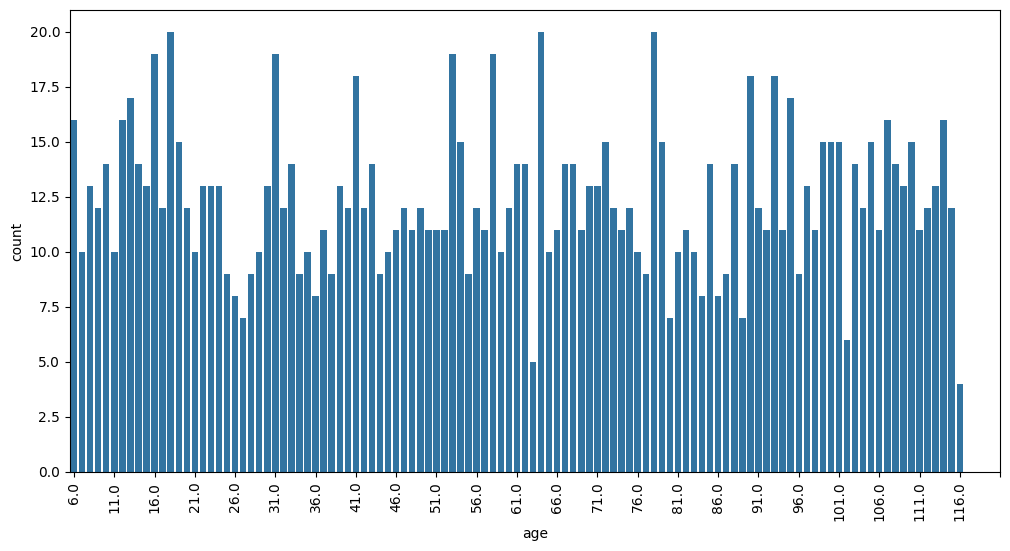

In [30]:
plt.figure(figsize=(12,6))
sns.countplot(x=users.age)
plt.xticks(range(0, 120, 5), rotation=90)
plt.show()

Z analýzy tohto údaju vieme, že vek ľudí sa pohybuje od 6 rokov do 116 rokov. Top 3 vekové skupiny sú 18, 64 a 78 rokov. Najmenšiu vekovú skupinu tvoria ľudia vo veku 116 rokov.

<AxesSubplot: ylabel='age'>

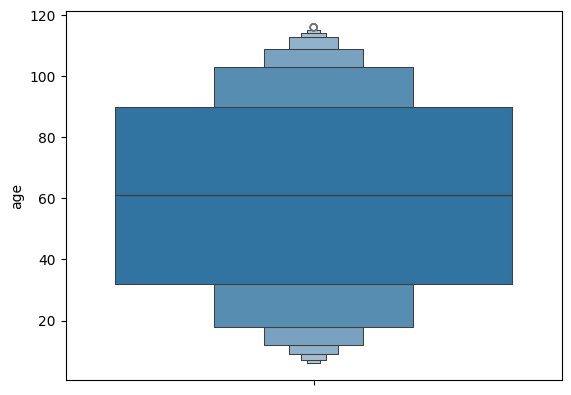

In [31]:
sns.boxenplot(y=users.age)

Z tohoto grafu napríklad vidíme, že väčšina ľudí, čo nakupovala online, je v rozmedzí približne 35 až 90 rokov

In [32]:
users.head()

,sex,user_id,current_location,address,job,name,race,mail,username,registration,birthdate,age
0,M,1270.0,"(Decimal('43.6199585'), Decimal('-39.027502'))",Samova 235 750 67 Police nad Metuji,Lawyer,MUDr. Premysl Riha,NaN,stastnyrostislav@seznam.cz,ales00,2023-08-23,1981-08-08,42.0
1,F,146.0,"(Decimal('67.5016935'), Decimal('169.135745'))",Doringstr. 1/8 09217 Stassfurt,Augenoptiker,Verena Zirme,NaN,marinaschueler@aol.de,schweitzertoni,2022-07-02,2010-09-15,13.0
2,NaN,2178.0,"(Decimal('-83.0843785'), Decimal('35.417096'))","Stretto Surian, 1 Appartamento 5 09071, Abbasa...",NaN,Sabatino Salvemini,NaN,alberto76@virgilio.it,rviviani,2017-10-26,1957-07-10,66.0
3,NaN,1211.0,"(Decimal('85.896300'), Decimal('-141.411207'))",Gang Shan Xian Wo Sun Zi Shi Shang Guang Gu 4D...,NaN,Qing Mu Ren,NaN,nishimuraasuka@yahoo.com,fmatsumoto,2020-02-22,1961-03-02,62.0
4,F,1678.0,"(Decimal('71.468916'), Decimal('-69.232181'))",USS Nelson FPO AE 34617,NaN,Vicki Lopez,NaN,ghowell@yahoo.com,nreed,2022-02-14,NaN,NaN


<AxesSubplot: xlabel='race'>

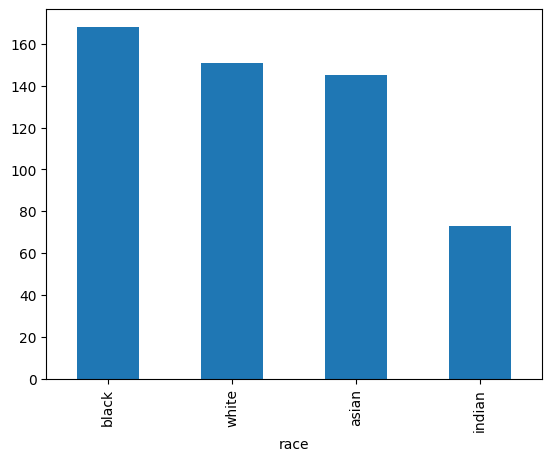

In [70]:
users.race.value_counts().plot(kind='bar')

<h4>Tabuľka products</h4>

V tabuľke products sa pozrieme na atribút **location**:

In [34]:
products.location.describe()

count                14912
unique                 184
top       America/New_York
freq                  1093
Name: location, dtype: object

In [35]:
prod_loc_val_counts = products.location.value_counts(); prod_loc_val_counts

location
America/New_York    1093
Asia/Kolkata        1037
Europe/Berlin        707
America/Chicago      705
Europe/London        596
                    ... 
Africa/Bamako         10
Europe/Sarajevo       10
America/Halifax       10
Africa/Blantyre        7
Asia/Bishkek           6
Name: count, Length: 184, dtype: int64

Keďže miest, odkiaľ si ľudia objednávali produkty je veľa, uvedieme pre zaujímavosť len top 20 miest

In [36]:
top_cities = prod_loc_val_counts.nlargest(20)
top_cities

location
America/New_York       1093
Asia/Kolkata           1037
Europe/Berlin           707
America/Chicago         705
Europe/London           596
Asia/Shanghai           580
Europe/Paris            512
Europe/Moscow           498
Europe/Rome             459
America/Los_Angeles     428
Asia/Tokyo              405
America/Sao_Paulo       363
Europe/Madrid           341
Asia/Manila             304
Asia/Jakarta            287
Asia/Karachi            260
America/Mexico_City     212
Africa/Lagos            195
Europe/Amsterdam        187
Asia/Bangkok            178
Name: count, dtype: int64

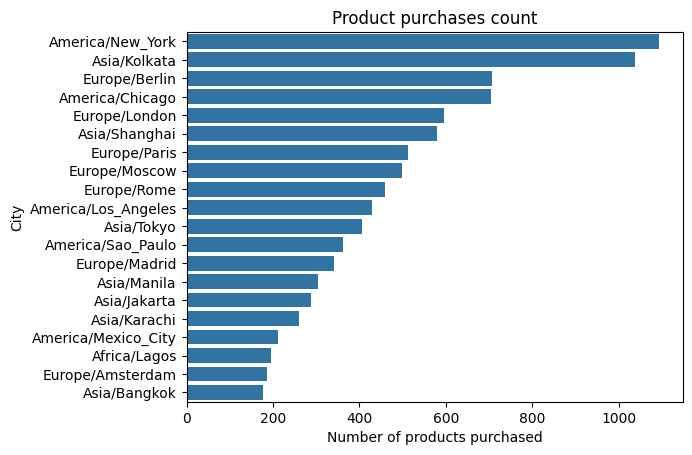

In [37]:
sns.barplot(x=top_cities.values, y=top_cities.index)

plt.title("Product purchases count")
plt.xlabel("Number of products purchased")
plt.ylabel("City")

plt.show()

Z predošlých dát vidíme, že najviac produktov si ľudia objednali z mesta New York v Amerike a najmenej z Bishkeku v Ázií.

<h4>Tabuľka sessions</h4>

Z tabuľky sessions sa pozrieme na viacero atribútov:
-ack
-total_load_time
-session_duration
-page_activity_duration
-scroll_move_total_rel_distance
-mouse_move_total_rel_distance
-pct_rage_click
-pct_click_product_info

In [38]:
sessions.head(10)

,pct_scroll_move,screen_width,ack,pct_mouse_move,scroll_move_total_rel_distance,page_activity_duration,pct_doubleclick,pct_click,total_load_time,mouse_move_total_rel_distance,product_ean,pct_click_product_info,screen_height,pct_wild_mouse,pct_mouse_click,pct_input,session_duration,wild_mouse_duration,session_start,pct_scroll_move_duration,pct_scrandom,pct_rage_click,session_id,user_id
0,44.92257,1366,1.0,8.79303,11.16238,5.45167,9.31170,10.35168,2.81337,7.79215,4142933212429,41.07557,1080,53.33923,10.65208,0.00646,116.78143,5.44105,2021-05-11 10:16:37,11.39851,60.96280,42.77314,1126926,2369
1,53.93169,1280,0.0,10.69797,13.20789,8.03161,11.33962,7.58887,0.11913,13.78957,6554259262213,52.52006,1080,69.70571,8.32826,0.07267,134.68835,9.51278,2023-07-07 17:38:03,9.48454,56.71155,30.83474,103955,1186
2,41.66225,800,1.0,11.45911,9.16087,7.73080,9.19028,8.11378,2.60292,5.95620,3525947927861,38.74596,768,72.87642,10.18567,0.02227,126.47138,8.10733,2019-07-24 12:15:27,9.51528,58.17433,39.30398,731099,1265
3,37.59937,800,1.0,9.78386,6.38416,9.70961,7.42759,6.54811,6.55699,6.36864,9631384503705,62.74747,600,54.03365,7.75790,0.05988,263.06076,9.31265,2022-06-10 17:52:37,4.91020,68.47422,46.14026,1379903,467
4,62.70254,1920,0.0,7.39008,6.09215,11.10614,10.94899,8.45322,0.85335,7.94163,2238487280389,41.10241,600,60.07533,7.59956,1.45341,146.88323,12.60862,2020-09-07 15:03:13,10.63283,28.45915,42.41093,691237,594
5,61.97286,1280,1.0,10.35223,5.75549,11.34581,6.57972,8.46953,4.14889,8.12832,1925267512228,32.17758,1080,53.84368,7.63618,0.66407,36.55669,11.81931,2021-01-26 02:26:58,7.86493,44.47547,31.27958,287548,98
6,37.95096,1280,0.0,7.44280,8.10008,10.43996,10.59187,8.61040,8.01728,8.13228,2703564692855,58.30562,600,55.99896,9.14538,0.13232,98.09171,10.14409,2022-08-07 04:30:11,11.22587,44.07244,33.52938,940408,1863
7,55.21370,800,1.0,9.43712,12.39561,6.35263,13.35800,8.59864,2.18870,8.09075,7291805451972,44.94427,600,54.95659,10.20664,0.01555,215.02259,7.40475,2019-01-03 03:39:41,13.31740,57.61754,39.41398,825526,1660
8,28.24404,1024,1.0,8.50688,10.82101,8.99179,11.15291,8.95374,3.24996,8.77909,3735846340948,43.06530,600,12.09002,10.54170,0.02515,205.55848,8.14649,2022-10-05 13:22:24,11.95009,28.93209,57.22930,261236,1491
9,65.33764,1024,0.0,9.62676,10.04908,7.22268,9.88599,9.36052,4.25322,10.13167,6642253975717,63.40218,800,64.24569,7.26089,0.05369,138.49897,9.22675,2019-07-03 09:10:44,9.81558,38.27188,60.19783,208595,1631


<h5>ACK</h5>

In [39]:
sessions.ack.describe()

count    10912.000000
mean         0.549487
std          0.497568
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: ack, dtype: float64

In [40]:
sessions.ack.value_counts()

ack
1.0    5996
0.0    4916
Name: count, dtype: int64

C:\Users\jakub\AppData\Local\Temp\ipykernel_15520\350989846.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=sessions.ack, palette="rocket")


<AxesSubplot: xlabel='ack', ylabel='count'>

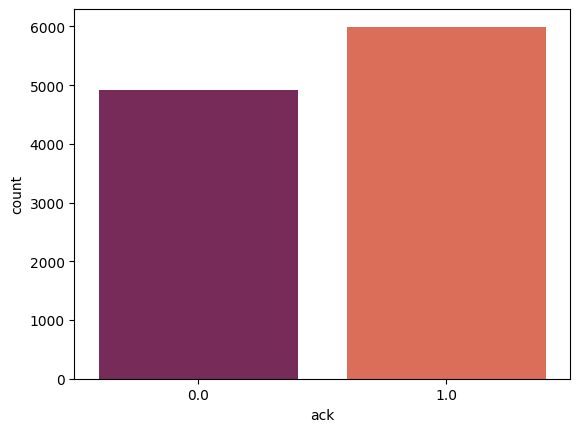

In [41]:
sns.countplot(x=sessions.ack, palette="rocket")

<h5>Total_load_time</h5>

In [42]:
sessions.total_load_time.describe()

count    10912.000000
mean         3.984017
std          2.817457
min          0.003570
25%          1.913255
50%          3.339890
75%          5.354380
max         23.487790
Name: total_load_time, dtype: float64

<AxesSubplot: ylabel='total_load_time'>

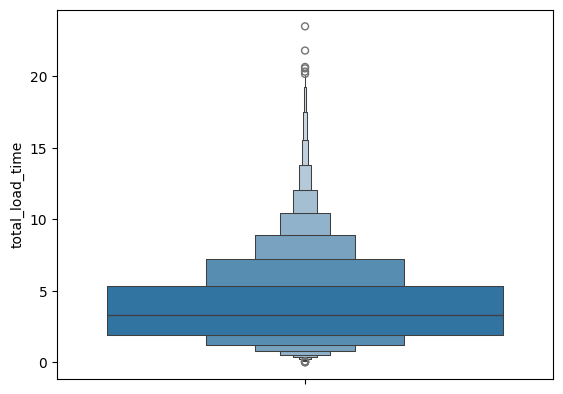

In [43]:
sns.boxenplot(y=sessions.total_load_time)

<AxesSubplot: xlabel='total_load_time', ylabel='Count'>

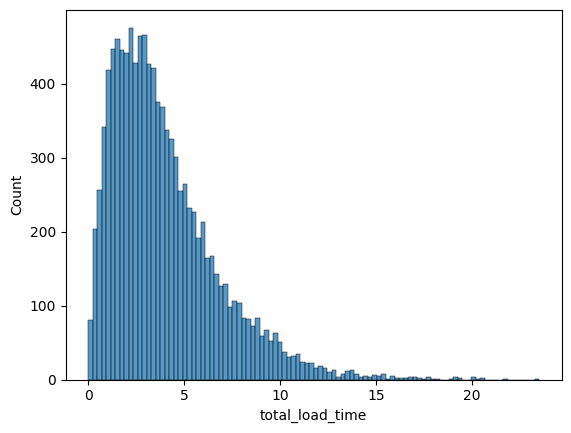

In [44]:
sns.histplot(sessions.total_load_time, bins=100)

<h5>Session duration</h5>

In [45]:
sessions.session_duration.describe()

count    10912.000000
mean       150.156130
std         60.380152
min        -47.247120
25%        109.037757
50%        151.104965
75%        190.967010
max        366.445590
Name: session_duration, dtype: float64

<AxesSubplot: ylabel='session_duration'>

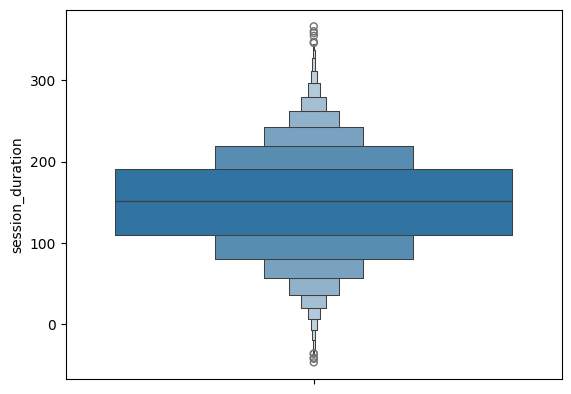

In [46]:
sns.boxenplot(y=sessions.session_duration)

<AxesSubplot: xlabel='session_duration', ylabel='Count'>

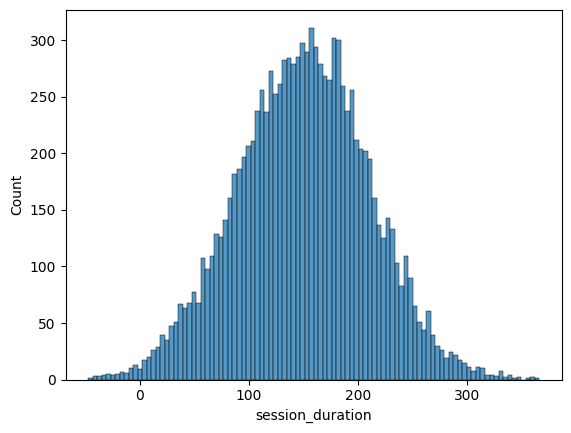

In [47]:
sns.histplot(sessions.session_duration, bins=100)

<h5>Page_Activity_duration</h5>

In [48]:
sessions.page_activity_duration.describe()

count    10901.000000
mean         9.045979
std          2.200557
min          2.812950
25%          7.305000
50%          9.048410
75%         10.749970
max         16.572150
Name: page_activity_duration, dtype: float64

<AxesSubplot: ylabel='page_activity_duration'>

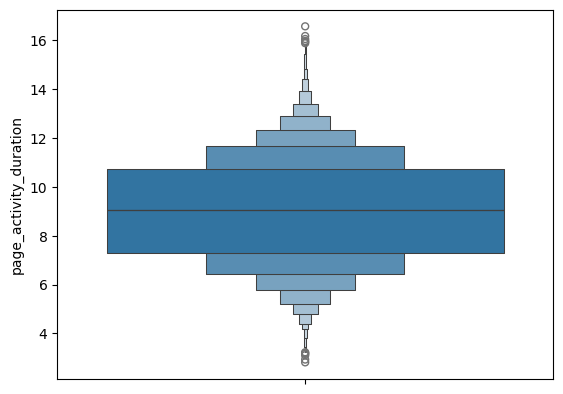

In [49]:
sns.boxenplot(y=sessions.page_activity_duration)

<AxesSubplot: xlabel='page_activity_duration', ylabel='Count'>

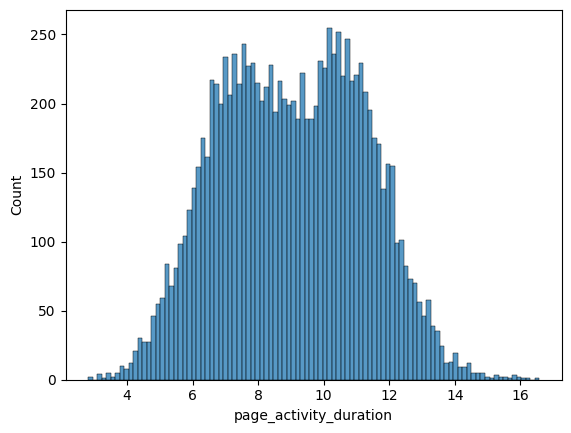

In [50]:
sns.histplot(sessions.page_activity_duration, bins=100)

<h5>Scroll_move_total_rel_distance</h5>

In [51]:
sessions.scroll_move_total_rel_distance.describe()

count    10901.000000
mean         9.436445
std          3.368335
min          0.000000
25%          6.725700
50%          9.017240
75%         12.184430
max         20.349730
Name: scroll_move_total_rel_distance, dtype: float64

<AxesSubplot: ylabel='scroll_move_total_rel_distance'>

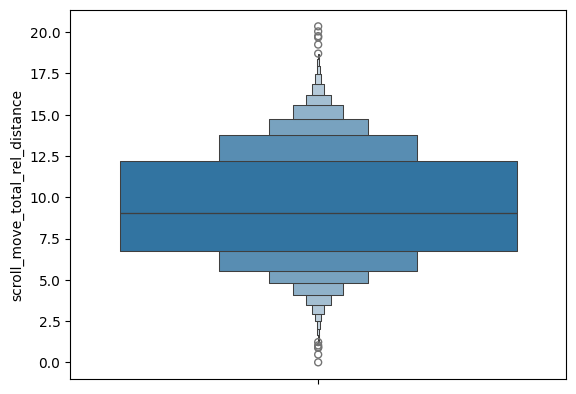

In [52]:
sns.boxenplot(y=sessions.scroll_move_total_rel_distance)

<AxesSubplot: xlabel='scroll_move_total_rel_distance', ylabel='Count'>

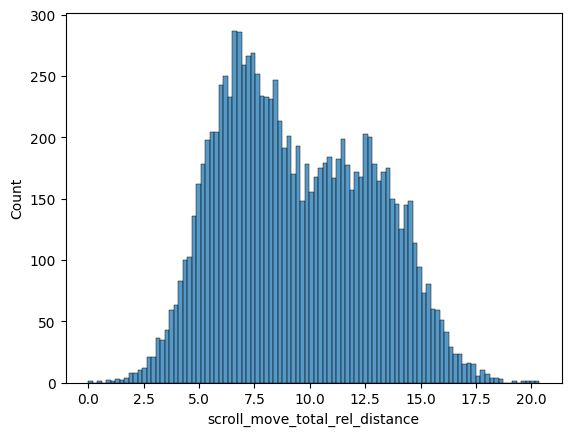

In [53]:
sns.histplot(sessions.scroll_move_total_rel_distance, bins=100)

<h5>Mouse_move_total_rel_distance</h5>

In [54]:
sessions.mouse_move_total_rel_distance.describe()

count    10901.000000
mean         8.116084
std          2.144984
min          1.228680
25%          6.593120
50%          7.980740
75%          9.646690
max         15.791510
Name: mouse_move_total_rel_distance, dtype: float64

<AxesSubplot: ylabel='mouse_move_total_rel_distance'>

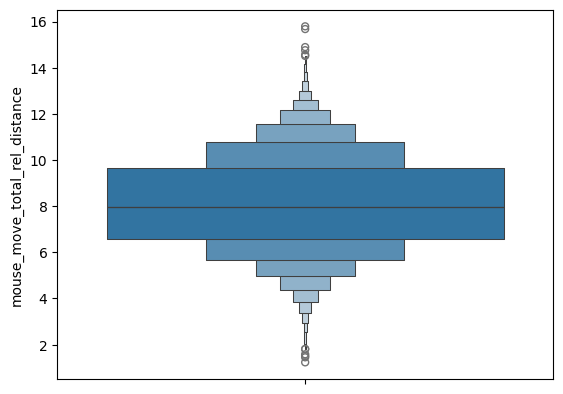

In [55]:
sns.boxenplot(y=sessions.mouse_move_total_rel_distance)

<AxesSubplot: xlabel='mouse_move_total_rel_distance', ylabel='Count'>

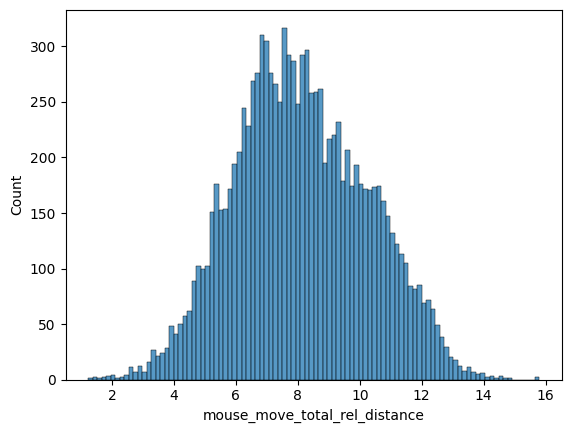

In [56]:
sns.histplot(sessions.mouse_move_total_rel_distance, bins=100)

<h5>Pct_rage_click</h5>

In [57]:
sessions.pct_rage_click.describe()

count    10901.000000
mean        51.156387
std         13.015218
min          0.000000
25%         42.558700
50%         51.049200
75%         59.896210
max        100.000000
Name: pct_rage_click, dtype: float64

<AxesSubplot: ylabel='pct_rage_click'>

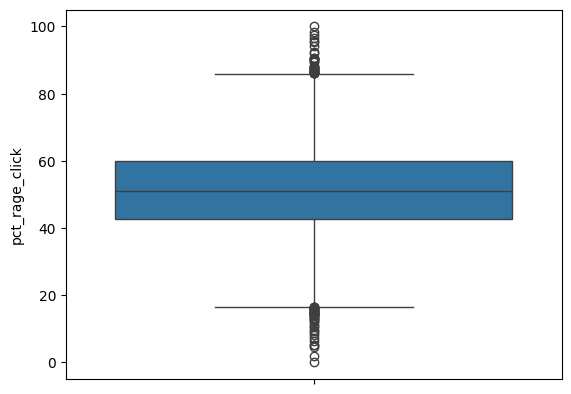

In [58]:
sns.boxplot(y=sessions.pct_rage_click)

<AxesSubplot: xlabel='pct_rage_click', ylabel='Count'>

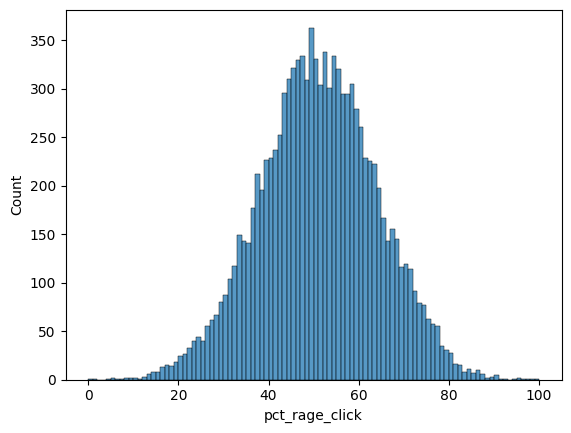

In [59]:
sns.histplot(sessions.pct_rage_click, bins=100)

<h5>Pct_click_product_info</h5>

In [60]:
sessions.pct_click_product_info.describe()

count    10901.000000
mean        51.341515
std         12.710060
min          0.000000
25%         42.752720
50%         51.307850
75%         59.880080
max        100.000000
Name: pct_click_product_info, dtype: float64

<AxesSubplot: ylabel='pct_click_product_info'>

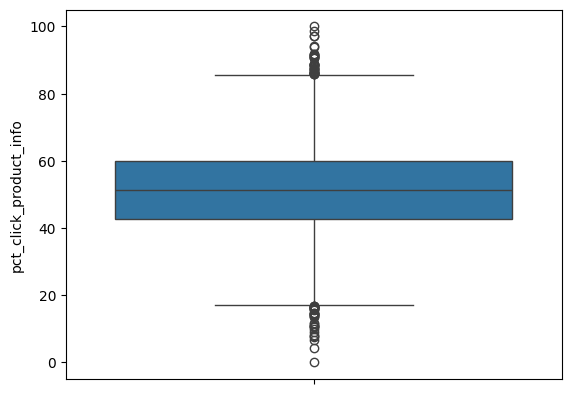

In [61]:
sns.boxplot(y=sessions.pct_click_product_info)

<AxesSubplot: xlabel='pct_click_product_info', ylabel='Count'>

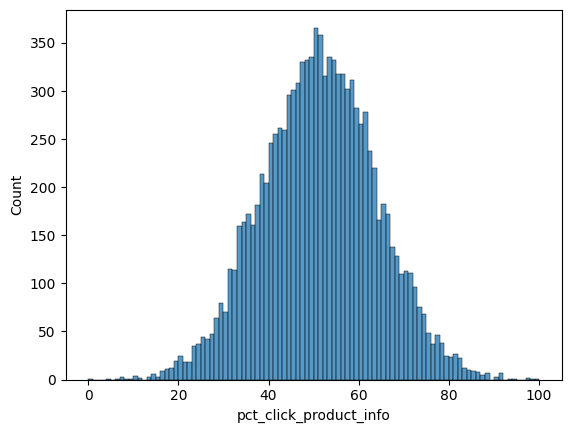

In [62]:
sns.histplot(sessions.pct_click_product_info, bins=100)

<h1>Párová analýza dát</h1>

In [63]:
clean_sessions = sessions.drop(["session_start", "session_id", "user_id"], axis=1)

Najprv si vykreslíme heat map na prezretie korelácií z tabuľky sessions:

<AxesSubplot: >

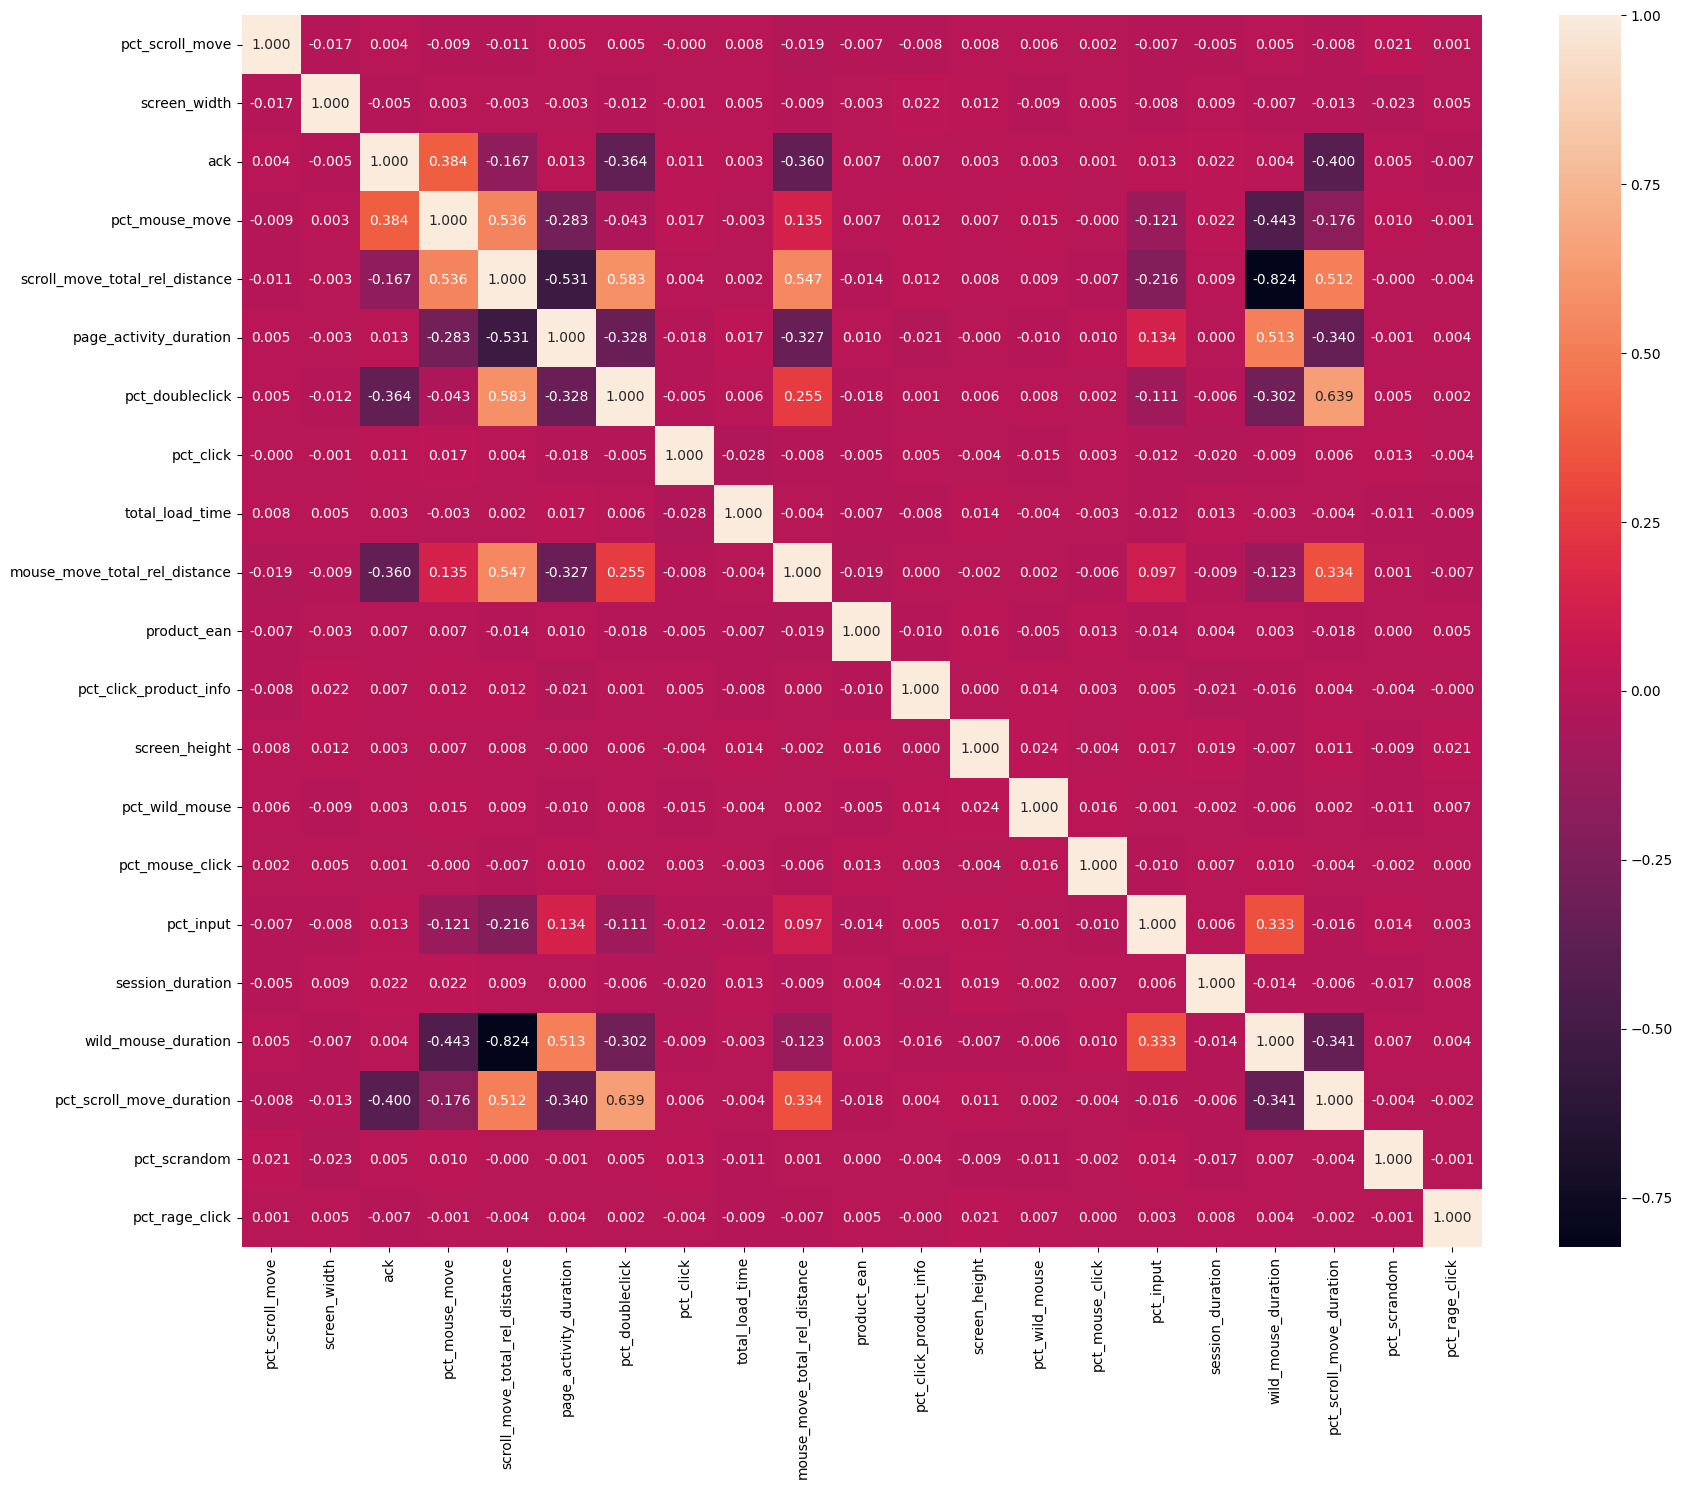

In [64]:
figure, ax = plt.subplots(figsize=(20,16))
sns.heatmap(clean_sessions.corr(),ax=ax, annot =True, fmt = ".3f")

Z heat mapy vidíme, že nasledovné atribúty skoro vôbec nekorelujú s ostatnými atribútmi:
<ul>
<li>pct_scroll_move
<li>screen_width
<li>pct_click
<li>total_load_time
<li>product_ean
<li>pct_click_product_info
<li>screen_height
<li>pct_wild_mouse
<li>pct_mouse_click
<li>session_duration
<li>pct_random
<li>pct_rage_click
</ul>

Následne v heat mape vidíme aj nejaké kladné korelácie. Je ich viacero, tak spomenieme len niektoré z nich:
<ul>
<li>pct_scroll_move_duration a pct_doubleclick
<li>scroll_move_total_rel_distance a pct_doubleclick
<li>mouse_move_total_rel_distance a scroll_move_total_rel_distance
<li><b>ack a pct_mouse_move</b>
</ul>

Uvedieme si aj pár negatívnych korelácií:
<ul>
<li>wild_mouse_duration a scroll_move_total_rel_distance
<li>page_activity_duration a scroll_move_total_rel_distance
<li>wild_mouse_duration a pct_mouse_move
<li><b>ack a pct_scroll_move_duration</b>
</ul>

KeyboardInterrupt: 

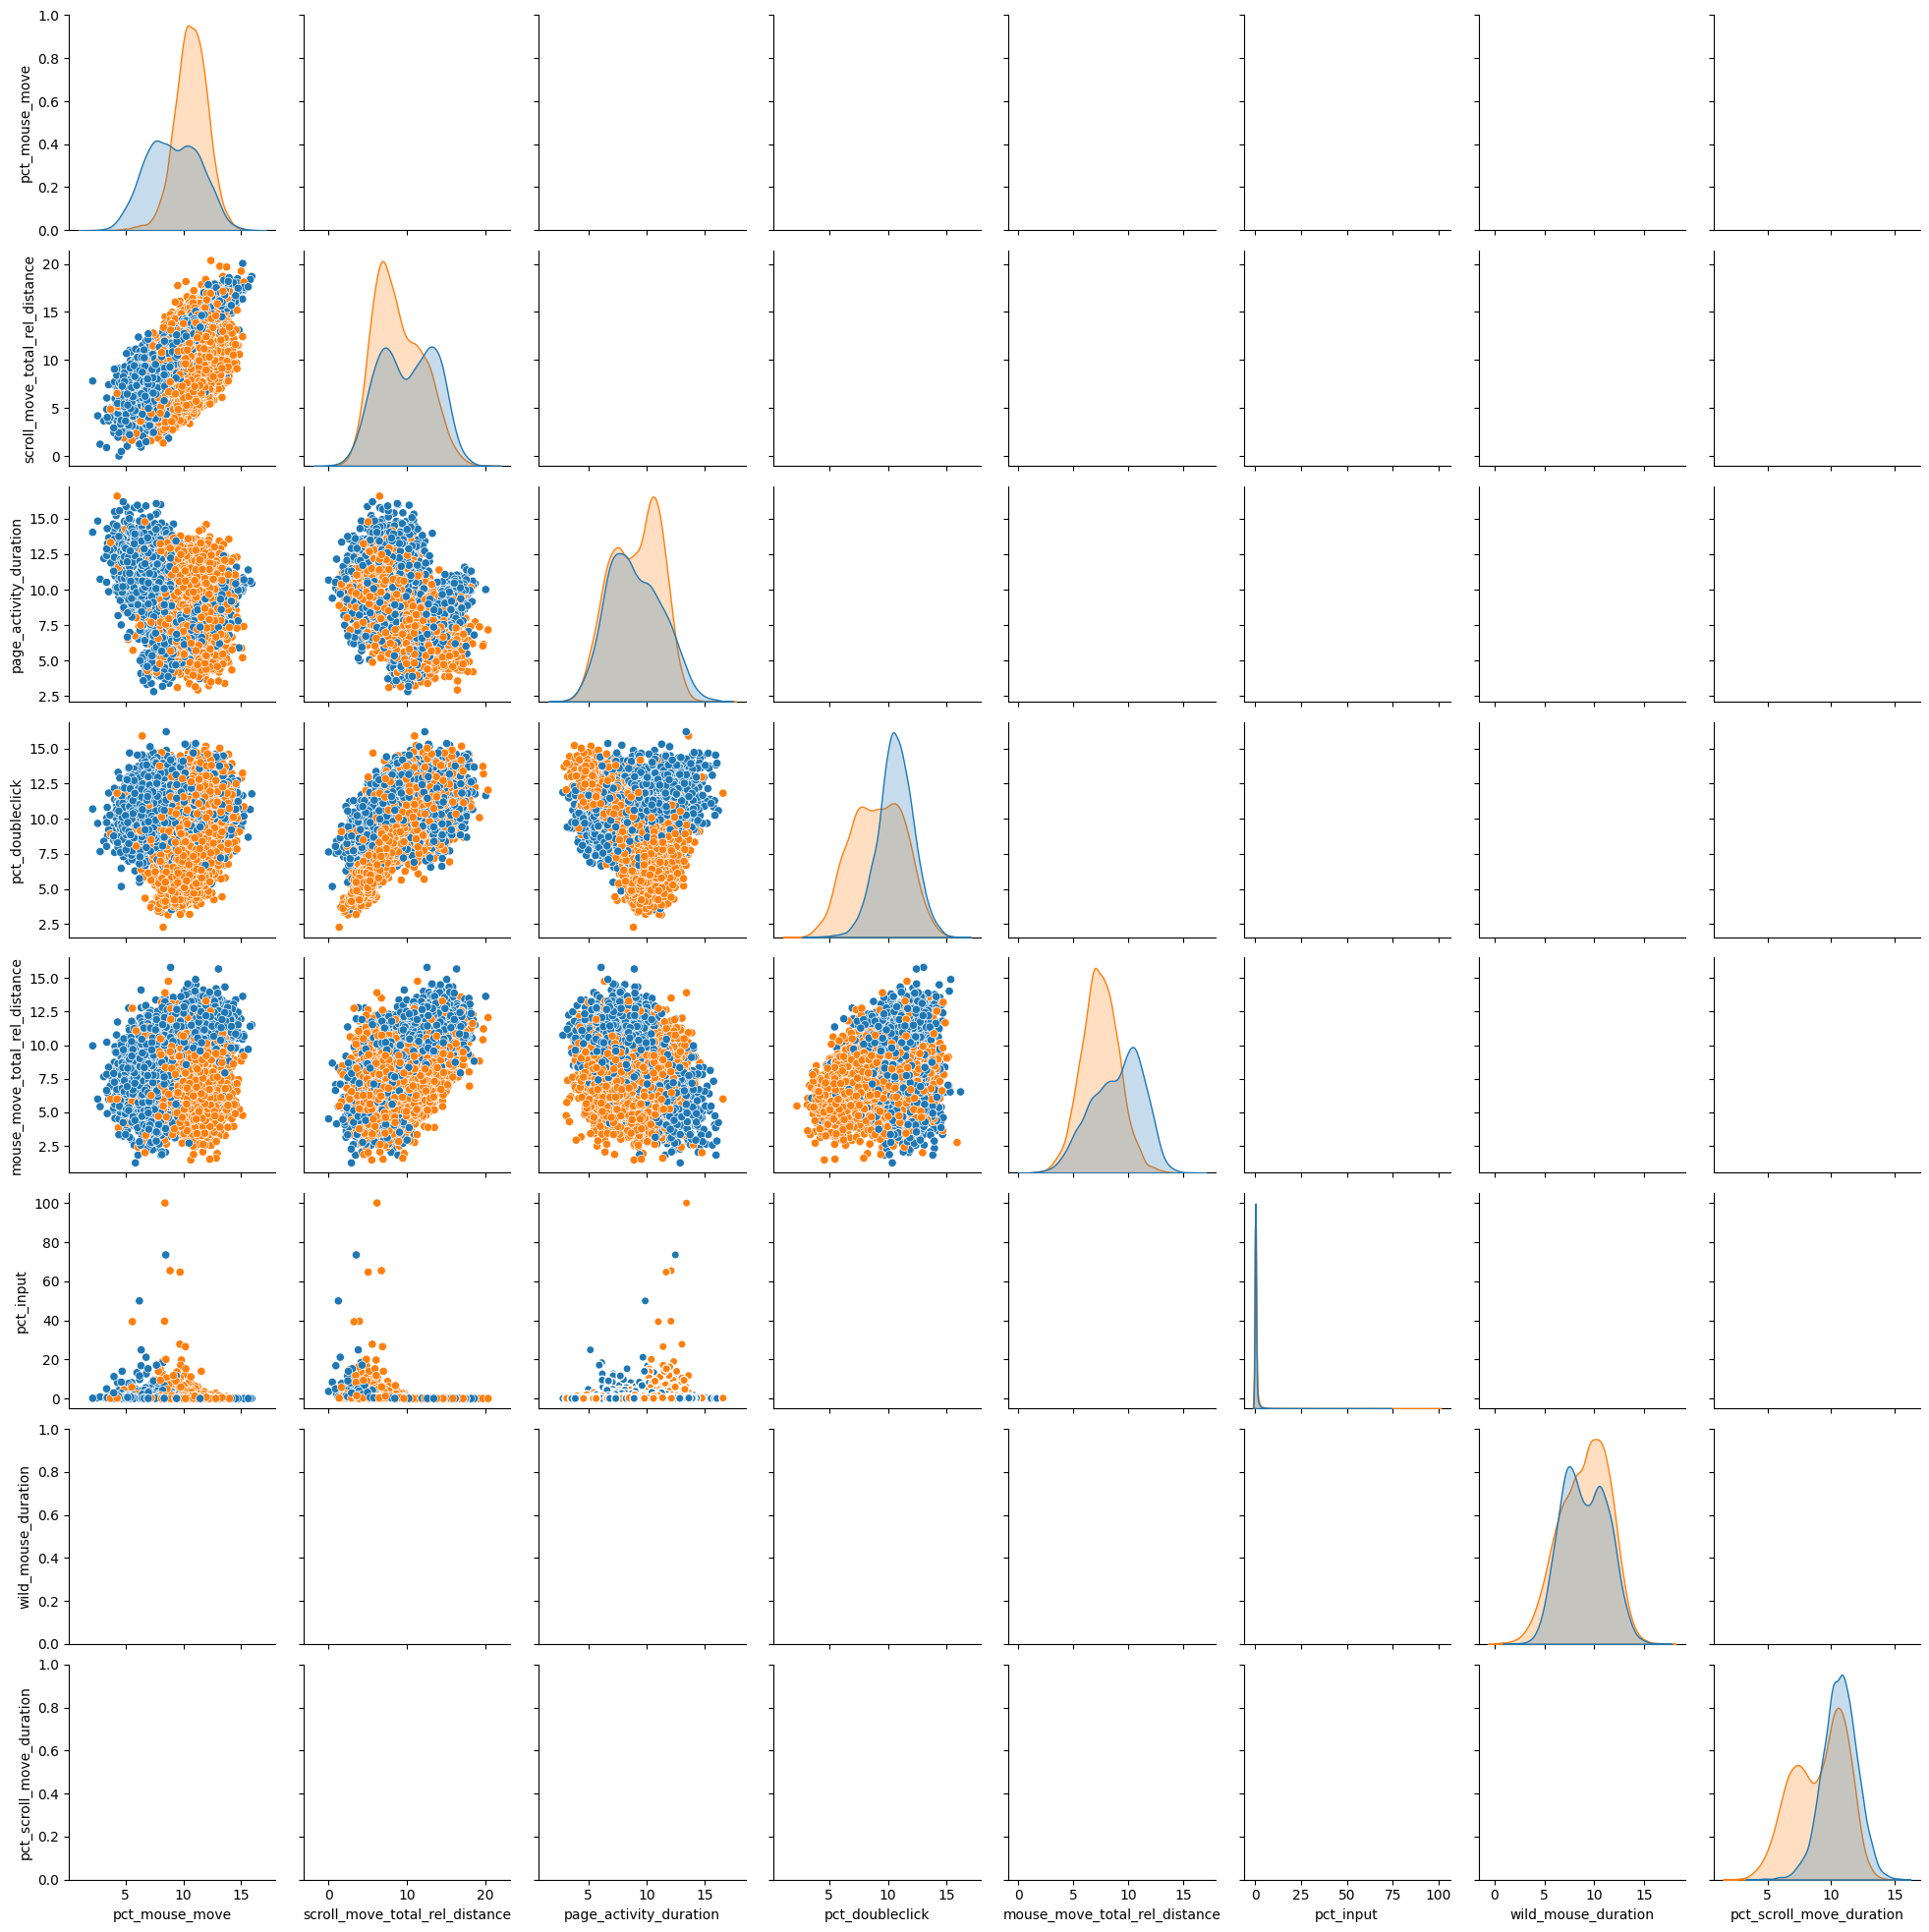

In [65]:
sns.pairplot(sessions, vars=['pct_mouse_move', 'scroll_move_total_rel_distance', 'page_activity_duration', 'pct_doubleclick', 'mouse_move_total_rel_distance', 'pct_input', 'wild_mouse_duration', 'pct_scroll_move_duration'], hue='ack', diag_kind='kde') #v tejto verzii su len atributy so silnejsimi korelaciami

'''sns.pairplot(sessions, vars=['pct_scroll_move', 'screen_width', 'pct_mouse_move', 'scroll_move_total_rel_distance', 'page_activity_duration', 'pct_doubleclick', 'pct_click', 'total_load_time', 'mouse_move_total_rel_distance', 'product_ean', 'pct_click_product_info', 'screen_height', 'pct_wild_mouse', 'pct_mouse_click', 'pct_input', 'session_duration', 'wild_mouse_duration', 'pct_scroll_move_duration', 'pct_scrandom', 'pct_rage_click'], hue='ack', diag_kind='kde')''' #vsetky atributy, pre pripad

Korelácia: -0.824


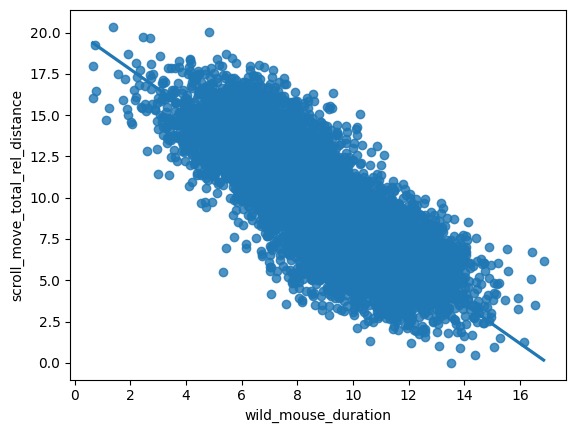

In [ ]:
sns.regplot(sessions, x='wild_mouse_duration', y='scroll_move_total_rel_distance')
print("Korelácia: %.3f" % sessions.wild_mouse_duration.corr(sessions.scroll_move_total_rel_distance))